# Heart Disease Detection

Problema consta in detectarea pacientilor cu boli de inima pe baza unui set de date, pe care am transformat-o intr-o simpla problema de clasificare binara (sanatos/bolnav).

Setul de date contine informatii despre peste 300 de pacienti care pot avea sau nu boli de inimă.
Coloanele sunt definite astfel:
- "age": varsta pacientului (ani)
- "sex": sexul pacientului (1 = masculin, 0 = feminin)
- "cp": tipul de durere toracică (valori discrete: 1, 2, 3, 4)
- "trestbps": tensiunea arterială la repaus (mm Hg)
- "chol": nivelul colesterolului seric (mg/dl)
- "fbs": zahar din sange în conditii de repaus (> 120 mg/dl este 1, altfel 0)
- "restecg": rezultate ale electrocardiogramei la repaus (valori discrete: 0, 1, 2)
- "thalach": rata maxima a inimii (bpm)
- "exang": angina indusa de efort (1 = da, 0 = nu)
- "oldpeak": depresiunea ST indusă de efort comparativ cu repausul
- "slope": panta segmentului ST (valori discrete: 1, 2, 3)
- "ca": numarul de vase majore colorate de fluoroscopie (0-3)
- "thal": defecte talasemie (valori discrete: 3 = normal, 6 = defect fix, 7 = defect reversibil)
- "num": eticheta originală (valori discrete: 0-4). Valorile mai mari de 0 indică prezența bolii.

Dintre acestea, cea mai relevanta coloana este "num" pe care o vom transforma intr-o eticheta pentru boala, unde 0- nu exista o boala si 1- exista un tip de boala, pentru a simplifica problema.


1. Importarea bibliotecilor necesare

Aceste biblioteci sunt folosite pentru procesarea datelor, reducerea dimensionalitatii, clasificare și evaluarea modelelor:
- `pandas` si `numpy`: pentru manipularea datelor.
- `sklearn`: pentru separarea setului de date, scalare, reducerea dimensionalitatii (PCA) si clasificare folosind Support Vector Classifier (SVC).
- `matplotlib.pyplot`: pentru vizualizarea rezultatelor.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

2. Incarcarea setului de date

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach",
    "exang", "oldpeak", "slope", "ca", "thal", "num"
]

data = pd.read_csv(url, header=None, names=columns, na_values="?")

3. Preprocesarea datelor
- am eliminat randurile cu valori lipsa daca exista
- am transformat coloana num intr-o variabila binara "target" cu valori de 0 si 1
- am separat datele atat in caracteristici si etichete (X si y) cat si in date de antrenare si de testare.
- pentru optimizarea performantei metodei folosite, am normalizat datele cu StandardScaler

In [3]:
data.dropna(inplace=True)

data['target'] = (data['num'] > 0).astype(int)
data.drop(columns=['num'], inplace=True)

X = data.drop(columns=['target'])
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

4. Reducerea dimensionalitatii folosind PCA (Principal Component Analysis)


PCA este utilizata pentru a reduce dimensionalitatea datelor, ceea ce poate avea mai multe avantaje:
- reducerea complexitatii modelului, scazand riscul de suprainvatare.
- cresterea vitezei de antrenare a modelului.
- eliminarea colinearitatii dintre caracteristici.
- metoda identifica directiile principale (componentele principale) in care datele variaza cel mai mult, transformand datele intr-un spatiu nou cu mai putine dimensiuni relevante.


In [50]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


5. Clasificarea utilizând SVC (Support Vector Classifier)

SVC este o metoda supervizata de invatare folosita pentru probleme de clasificare binara.
Functionare:
- creeaza un hiperplan intr-un spatiu multi-dimensional care separa categoriile de date.
 - utilizeaza "margea maxima", adica distanta maxima dintre punctele de date ale categoriilor și hiperplanul de separare.

 Spre deosebire de SVM (Support Vector Machine), SVC este o implementare specifica pentru clasificare. SVC suporta kernel-uri non-liniare (precum RBF), ceea ce încurajează utilizarea sa în cazul datelor complexe care nu sunt separabile liniar.


In [51]:
svm_original = SVC(kernel='rbf', C=0.1, random_state=42)
svm_original.fit(X_train_scaled, y_train)
y_pred_original = svm_original.predict(X_test_scaled)

svm_pca = SVC(kernel='rbf', C=0.1, random_state=42)
svm_pca.fit(X_train_pca, y_train)
y_pred_pca = svm_pca.predict(X_test_pca)

In acest caz, datorita capacitatii metodei SVC de a fi aplicata pentru orice kernel, am folosit si unul liniar, insa acuratetea a fost putin mai slaba.

6. Evaluarea modelului

 Dupa antrenarea modelului, evaluam performanta:
 - Acuratetea: proportia etichetelor corecte din totalul etichetelor clasificate.
 - Matricea de confuzie: arata numarul de clasificari corecte și incorecte.
 - Raportul de clasificare: ofera precision, recall, f1-score și support.

Evaluare pe datele originale:
Acuratețe: 0.87
Raport de clasificare:
              precision    recall  f1-score   support

           0       0.82      0.96      0.88        48
           1       0.94      0.76      0.84        42

    accuracy                           0.87        90
   macro avg       0.88      0.86      0.86        90
weighted avg       0.88      0.87      0.86        90



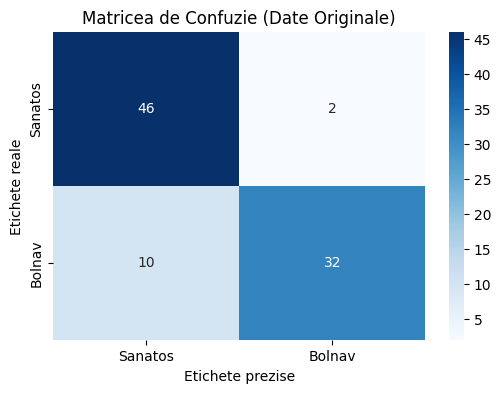

In [52]:
import seaborn as sns

print("Evaluare pe datele originale:")
print(f"Acuratețe: {accuracy_score(y_test, y_pred_original):.2f}")
print("Raport de clasificare:")
print(classification_report(y_test, y_pred_original))
plt.figure(figsize=(6, 4))
matrice_confuzie_original = confusion_matrix(y_test, y_pred_original)
sns.heatmap(matrice_confuzie_original, annot=True, fmt="d", cmap="Blues", xticklabels=["Sanatos", "Bolnav"], yticklabels=["Sanatos", "Bolnav"])
plt.title("Matricea de Confuzie (Date Originale)")
plt.xlabel("Etichete prezise")
plt.ylabel("Etichete reale")
plt.show()



Evaluare pe datele reduse cu PCA:
Acuratețe: 0.86
Raport de clasificare:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88        48
           1       0.94      0.74      0.83        42

    accuracy                           0.86        90
   macro avg       0.87      0.85      0.85        90
weighted avg       0.87      0.86      0.85        90



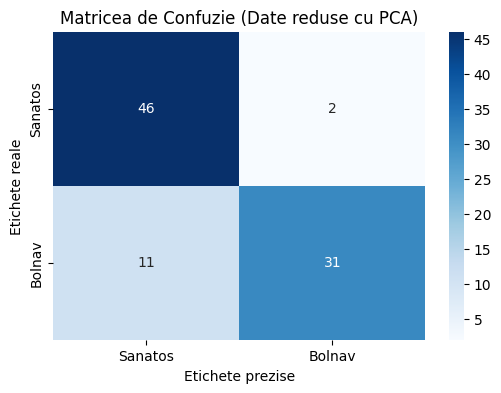

In [54]:
print("\nEvaluare pe datele reduse cu PCA:")
print(f"Acuratețe: {accuracy_score(y_test, y_pred_pca):.2f}")
print("Raport de clasificare:")
print(classification_report(y_test, y_pred_pca))

plt.figure(figsize=(6, 4))
matrice_confuzie_PCA = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(matrice_confuzie_PCA, annot=True, fmt="d", cmap="Blues", xticklabels=["Sanatos", "Bolnav"], yticklabels=["Sanatos", "Bolnav"])
plt.title("Matricea de Confuzie (Date reduse cu PCA)")
plt.xlabel("Etichete prezise")
plt.ylabel("Etichete reale")
plt.show()

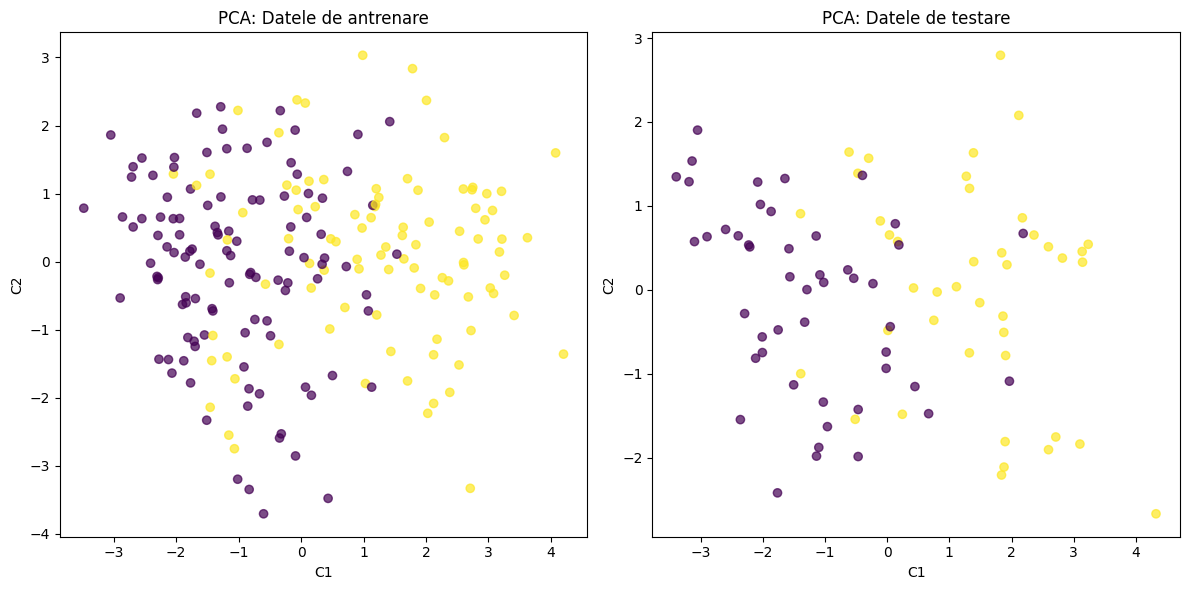

In [58]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.title("PCA: Datele de antrenare")
plt.xlabel("C1")
plt.ylabel("C2")

plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7)
plt.title("PCA: Datele de testare")
plt.xlabel("C1")
plt.ylabel("C2")

plt.tight_layout()
plt.show()

#C1 si C2 sunt combinatii liniare intre caracteristicile originale
#C1 este directia principala de variatie, iar C2 a doua directie de variatie, ortogonala (perpendiculara) fata de C1
#In loc sa vizualizam si sa lucram cu toate caracteristicile (13), PCA reduce datele la 2 dimensiuni (C1 si C2), pastrand cat mai mult din informatia esentiala